# Предсказание коэффициента восстановления золота

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В распоряжении имеются данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

______

###### Данное исследование разделено на несколько частей.

* [1. Подготовка данных.](#section1)
* [2. Исследовательский анализ.](#section2)
* [3. Построение модели.](#section3)
* [4. Выводы.](#section4)

______

<a id='section1'> </a>

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.dummy import DummyRegressor
from tqdm.notebook import tqdm
from catboost import Pool, cv, CatBoostRegressor
np.set_printoptions(precision=4)

In [2]:
train = pd.read_csv('./datasets/gold_recovery_train.csv')
train_init_len = len(train)

In [3]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Практически все колонки в данных - числовые. Единственным исключением является колонка date которую далее необходимо преобразовать к типу datetime. Так же в данных имеются пропуски их необходимо заполнить до создания моделей. Прочитаем остальные таблицы.

In [5]:
test = pd.read_csv('./datasets/gold_recovery_test.csv')
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [7]:
full = pd.read_csv('./datasets/gold_recovery_full.csv')

In [8]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Проверим что сумма длин тестовой и обучающей выборки равна длине полной выборки 

In [9]:
len(test) + len(train) == len(full)

True

Преобразуем столбец date во всех датафреймах к типу datetime

In [10]:
train['date']

0        2016-01-15 00:00:00
1        2016-01-15 01:00:00
2        2016-01-15 02:00:00
3        2016-01-15 03:00:00
4        2016-01-15 04:00:00
                ...         
16855    2018-08-18 06:59:59
16856    2018-08-18 07:59:59
16857    2018-08-18 08:59:59
16858    2018-08-18 09:59:59
16859    2018-08-18 10:59:59
Name: date, Length: 16860, dtype: object

In [11]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S')
train['date']

0       2016-01-15 00:00:00
1       2016-01-15 01:00:00
2       2016-01-15 02:00:00
3       2016-01-15 03:00:00
4       2016-01-15 04:00:00
                ...        
16855   2018-08-18 06:59:59
16856   2018-08-18 07:59:59
16857   2018-08-18 08:59:59
16858   2018-08-18 09:59:59
16859   2018-08-18 10:59:59
Name: date, Length: 16860, dtype: datetime64[ns]

In [12]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%d %H:%M:%S')

Заполним пропуски в данных. Для начала оценим какая доля данных пропущена в столбце rougher.output.concentrate_au

In [13]:
train['rougher.output.concentrate_au'].isna().mean()

0.004863582443653618

Так как доля данных строк заниемает менее 0,5% данные строки можно удалить из датасетов 

In [14]:
train = train.drop(train.index[train['rougher.output.concentrate_au'].isna()])
full = full.drop(full.index[full['rougher.output.concentrate_au'].isna()])

In [15]:
# проверим что функция сработала так как задуманно
train['rougher.output.concentrate_au'].isna().mean()

0.0

Аналогично оценим долю пропущеных данных в столбце rougher.input.feed_au. Так как нас интересуют предсказания доли золота по окончанию техпроцесса, то строки для которых доля золота в исходном сырье равна нулю так же из датасетов исключим

In [16]:
train['rougher.input.feed_au'].isna().mean()

5.960185957801883e-05

In [17]:
(train['rougher.input.feed_au'] == 0).mean()

0.06907855525092382

In [18]:
# удалим из обучающего датасета строки в которых данные о содержании золота в исходном сырье незаполнены
# или содержание золота равно нулю
train = train.drop(train.index[train['rougher.input.feed_au'].isna()])
train = train.drop(train.index[train['rougher.input.feed_au'] == 0])
test = test.drop(test.index[test['rougher.input.feed_au'].isna()])
test = test.drop(test.index[test['rougher.input.feed_au'] == 0])
full = full.drop(full.index[full['rougher.input.feed_au'].isna()])
full = full.drop(full.index[full['rougher.input.feed_au'] == 0])

In [19]:
# проверим что функция сработала так как задуманно
full['rougher.input.feed_au'].isna().mean()

0.0

Оценим долю незаполненных строк в столбце rougher.output.tail_au

In [20]:
full['rougher.output.tail_au'].isna().mean()

0.0567594480534876

Доля незаполненных строк в данном столбце приближается к 6% и удалять их не желательно. Оценим распределение по данному параметру

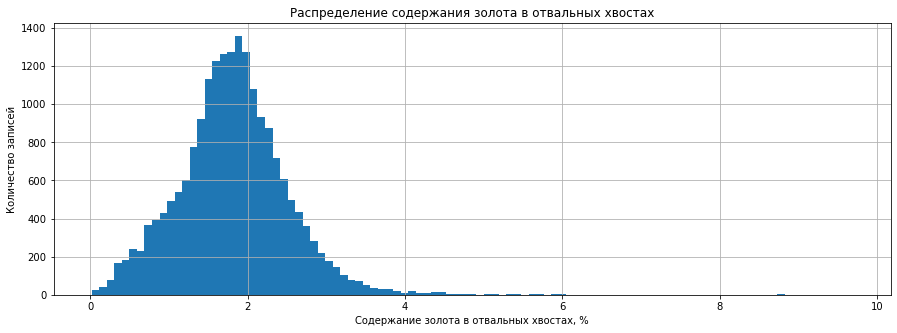

In [21]:
(full['rougher.output.tail_au'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Содержание золота в отвальных хвостах, %', 
      ylabel='Количество записей',  
      title='Распределение содержания золота в отвальных хвостах'));

In [22]:
train['rougher.output.tail_au'].describe()

count    14547.000000
mean         1.761855
std          0.730830
min          0.020676
25%          1.310091
50%          1.744990
75%          2.188485
max          9.688980
Name: rougher.output.tail_au, dtype: float64

Распределение близко к нормальному. Медиана не сильно отличается от среднего значения, а значит в распределении не существенных выбросов. Заполним пропуски средними значениями расчитанными по тестовой выборке

In [23]:
train['rougher.output.tail_au'] = train['rougher.output.tail_au'].fillna(train['rougher.output.tail_au'].mean())
full['rougher.output.tail_au'] = full['rougher.output.tail_au'].fillna(train['rougher.output.tail_au'].mean())

In [24]:
# проверим что замена прошла так как задуманно
(full['rougher.output.tail_au']).isna().mean()

0.0

Так же исключим из данных случаи когда на стадии флотаци все выходное золото остается в "хвостах"

In [25]:
train = train.drop(train.index[train['rougher.output.concentrate_au'] == train['rougher.output.tail_au']])
full = full.drop(full.index[full['rougher.output.concentrate_au'] == full['rougher.output.tail_au']])

In [26]:
# проверка
(train['rougher.output.concentrate_au'] == train['rougher.output.tail_au']).mean()

0.0

Так же из данных необходимо исключить случаи когда содержание золота в "хвостах" больше чем содержание золота в исходном сырье

In [27]:
(train['rougher.input.feed_au'] < train['rougher.output.tail_au']).mean()

0.028364707388910233

In [28]:
train = train.drop(train.index[train['rougher.input.feed_au'] < train['rougher.output.tail_au']])
full = full.drop(full.index[full['rougher.input.feed_au'] < full['rougher.output.tail_au']])
# проверка
(train['rougher.input.feed_au'] < train['rougher.output.tail_au']).mean()

0.0

Оценим эффективность обогащения на стадии флотации на тестовой выборке по заданным формулам

In [29]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']
train['rougher.output.recovery_manual_calc'] = (c * (f - t)) / (f * (c - t)) * 100

In [30]:
c = full['rougher.output.concentrate_au']
f = full['rougher.input.feed_au']
t = full['rougher.output.tail_au']
full['rougher.output.recovery_manual_calc'] = (c * (f - t)) / (f * (c - t)) * 100

Оценим на сколько близка оценка обогащения полученная по формуле к оценке приведенной в датасете (для заполненных строк)

In [31]:
full_rougher_notna_index = full.index[full['rougher.output.recovery'].notna()]
mean_absolute_error(full.loc[full_rougher_notna_index, 'rougher.output.recovery'], 
                    full.loc[full_rougher_notna_index, 'rougher.output.recovery_manual_calc'])

9.823469458453012e-15

Оценки практически идентичны. 

Аналогично подготовим исходные данные и оценим по формуле эффективность обогащения по итогам всего техпроцесса

In [32]:
# доля строк для которых финальная концентрация золота равна нулю
train['final.output.concentrate_au'].isna().mean()

0.00032948929159802305

In [33]:
train = train.drop(train.index[train['final.output.concentrate_au'].isna()])
full = full.drop(full.index[full['final.output.concentrate_au'].isna()])
train['final.output.concentrate_au'].isna().mean()

0.0

In [34]:
#доля строк для которых концентрация золота по выходу первичной очистки равна нулю
(train['primary_cleaner.output.concentrate_au'] == 0).mean()

0.00988793671720501

In [35]:
train = train.drop(train.index[train['primary_cleaner.output.concentrate_au'] == 0])
full = full.drop(full.index[full['primary_cleaner.output.concentrate_au'] == 0])
(train['primary_cleaner.output.concentrate_au'] == 0).mean()

0.0

In [36]:
# так же удалим строки для которых итоговая концентрация равна концентрации в хвостах
train = train.drop(train.index[train['final.output.concentrate_au'] == train['final.output.tail_au']])
full = full.drop(full.index[full['final.output.concentrate_au'] == full['final.output.tail_au']])

In [37]:
# строки в которых содержание золота в исходном сырье меньше чем содержание золота в хвостах
(train['primary_cleaner.output.concentrate_au'] < train['final.output.tail_au']).mean()

0.011412934659280519

In [38]:
train = train.drop(train.index[train['primary_cleaner.output.concentrate_au'] < train['final.output.tail_au']])
full = full.drop(full.index[full['primary_cleaner.output.concentrate_au'] < full['final.output.tail_au']])
# проверка
(train['primary_cleaner.output.concentrate_au'] < train['final.output.tail_au']).mean()

0.0

In [39]:
c = train['final.output.concentrate_au']
f = train['primary_cleaner.output.concentrate_au']
t = train['final.output.tail_au']
train['final.output.recovery_manual_calc'] = (c * (f - t)) / (f * (c - t)) * 100

In [40]:
c = full['final.output.concentrate_au']
f = full['primary_cleaner.output.concentrate_au']
t = full['final.output.tail_au']
full['final.output.recovery_manual_calc'] = (c * (f - t)) / (f * (c - t)) * 100

Оценим на сколько близка оценка обогащения полученная по формуле к оценке приведенной в датасете (для заполненных строк)

In [41]:
full_final_notna_index = full.index[(full['final.output.recovery'].notna()) & 
                                    (full['final.output.recovery_manual_calc'].notna())]
mean_absolute_error(full.loc[full_final_notna_index, 'final.output.recovery'], 
                    full.loc[full_final_notna_index, 'final.output.recovery_manual_calc'])

29.65250364043836

Точность оценки обогащения по результатам всех стадий технологического цикла (по формуле) ниже, чем точность отдельно для стадии флотации. Запролним пропущенные строки расчетными значениями.

In [42]:
train['rougher.output.recovery'] = train['rougher.output.recovery'].fillna(train['rougher.output.recovery_manual_calc'])
train['rougher.output.recovery'].isna().mean()

0.0

In [43]:
train['final.output.recovery'] = train['final.output.recovery'].fillna(train['final.output.recovery_manual_calc'])
train['final.output.recovery'].isna().mean()

0.0

In [44]:
full['rougher.output.recovery'] = full['rougher.output.recovery'].fillna(full['rougher.output.recovery_manual_calc'])
full['final.output.recovery'] = full['final.output.recovery'].fillna(full['final.output.recovery_manual_calc'])

Построим гистограмму распределения эффективности обогащения после стадии флотации и финальной стадии.

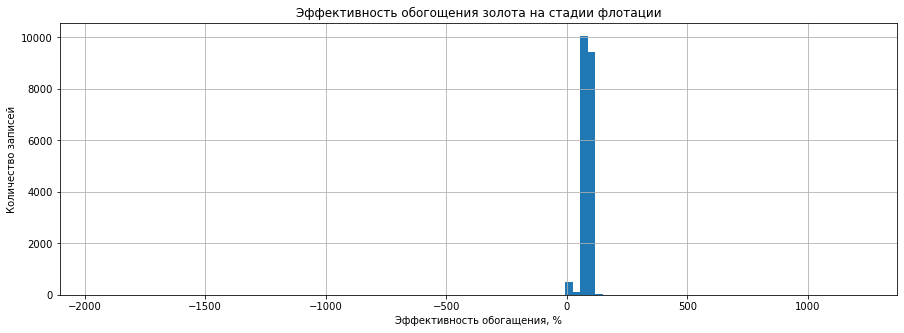

In [45]:
(full['rougher.output.recovery'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Эффективность обогащения, %', 
      ylabel='Количество записей',  
      title='Эффективность обогощения золота на стадии флотации'));

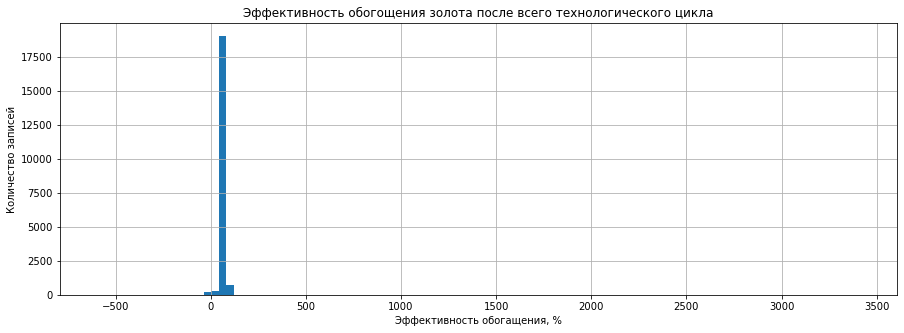

In [46]:
(full['final.output.recovery'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Эффективность обогащения, %', 
      ylabel='Количество записей',  
      title='Эффективность обогощения золота после всего технологического цикла'));

Видно, что в распределениях встечаются аномалии. Удалим из датасетов все значения меньше либо равные нулю и более либо равные 100 %

In [47]:
((train['rougher.output.recovery'] <= 0) | (train['rougher.output.recovery'] >= 100)).mean()

0.03645692681609506

In [48]:
train = train.drop(train.index[(train['rougher.output.recovery'] <= 0) | (train['rougher.output.recovery'] >= 100)])
train = train.drop(train.index[(train['final.output.recovery'] <= 0) | (train['final.output.recovery'] >= 100)])
full = full.drop(full.index[(full['rougher.output.recovery'] <= 0) | (full['rougher.output.recovery'] >= 100)])
full = full.drop(full.index[(full['final.output.recovery'] <= 0) | (full['final.output.recovery'] >= 100)])

Еще раз посмотрим на гистограммы после удаления аномалий

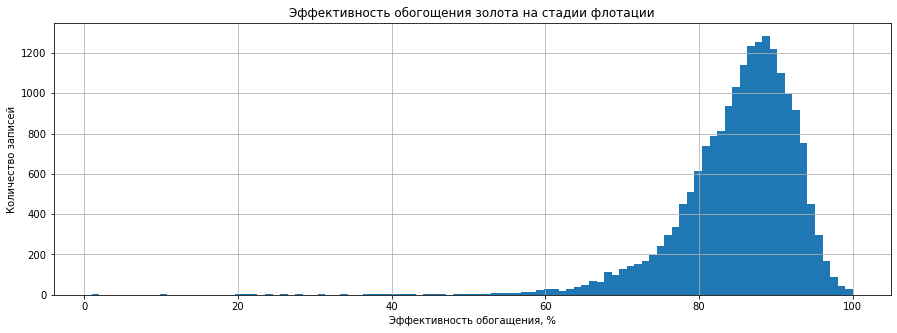

In [49]:
(full['rougher.output.recovery'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Эффективность обогащения, %', 
      ylabel='Количество записей',  
      title='Эффективность обогощения золота на стадии флотации'));

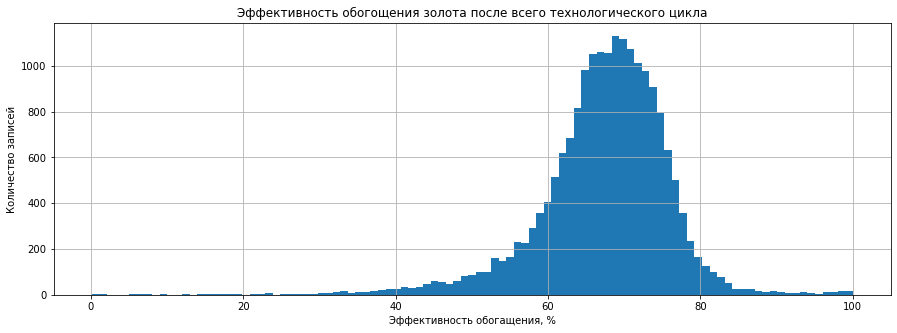

In [50]:
(full['final.output.recovery'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Эффективность обогащения, %', 
      ylabel='Количество записей',  
      title='Эффективность обогощения золота после всего технологического цикла'));

Добавим в тестовую выборку столбцы rougher.output.recovery и final.output.recovery по соответствующим датам

In [51]:
test = test.merge(full.loc[:,['date','rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

Строки в которых целевые признаки заменить не удалось удалим

In [52]:
test = test.drop(test.index[test['final.output.recovery'].isna()])
test['final.output.recovery'].isna().sum()

0

In [53]:
test = test.drop(test.index[test['rougher.output.recovery'].isna()])
test['rougher.output.recovery'].isna().sum()

0

Поскольку данные упорядочены по дате, а по условиям задачи соседние по времени параметры похожи, то остальные проруски в данных заполним ближайшими значениямиями. Заполнять будем только те столбцы которые имеются в тестовой выборке (в тестовой выборке нет признаков final.* и * .calculation.* )

In [54]:
train[test.columns] = train[test.columns].fillna(method='ffill')
test = test.fillna(method='ffill')

Проверим что в датасетах больше нет пропусков

In [55]:
train[test.columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14063 entries, 0 to 16859
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14063 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               14063 non-null  float64       
 2   primary_cleaner.input.depressant            14063 non-null  float64       
 3   primary_cleaner.input.feed_size             14063 non-null  float64       
 4   primary_cleaner.input.xanthate              14063 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      14063 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    14063 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      14063 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    14063 non-null  float64       
 9   primar

In [56]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5171 entries, 0 to 5470
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5171 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5171 non-null   float64       
 2   primary_cleaner.input.depressant            5171 non-null   float64       
 3   primary_cleaner.input.feed_size             5171 non-null   float64       
 4   primary_cleaner.input.xanthate              5171 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5171 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5171 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5171 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5171 non-null   float64       
 9   primary_

В заключении данного раздела оценим суммарное количество строк в обучающей выборке, удаленных в процессе предобработки

In [57]:
print('Суммарное количество удаленных в процессе предобработки строк в обучающей выборке {:.1%}'.format(
                                                                                            1 - (len(train) / train_init_len)))

Суммарное количество удаленных в процессе предобработки строк в обучающей выборке 16.6%


<a id='section2'> </a>

# 2. Анализ данных

## 2.1 Оценка изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки

**Золото**

Оценим как меняется концентрация золота при переходе от одной стадии техпроцесса к другой. Построим на графике первые 10 реализаций процесса.

In [58]:
au = train[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au',
            'final.output.concentrate_au']]

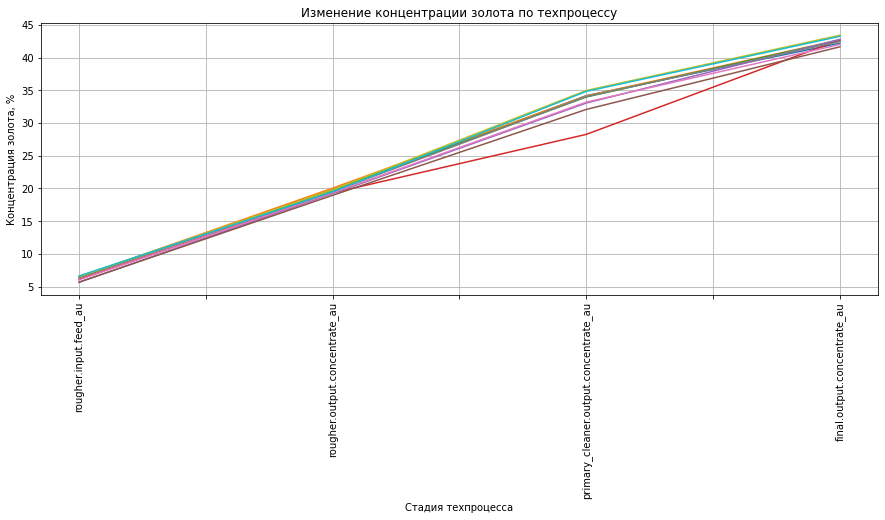

In [59]:
for i in range(0,10):
    (au.loc[i].plot(rot=90, grid=True, figsize=(15, 5)) 
     .set(xlabel='Стадия техпроцесса', 
      ylabel='Концентрация золота, %',  
      title='Изменение концентрации золота по техпроцессу'));

Видно что концентрация золота от стадии к стадии растет. Проведем аналогичное исследование для концентрации серебра

**Серебро**

In [60]:
ag = train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag',
            'final.output.concentrate_ag']]

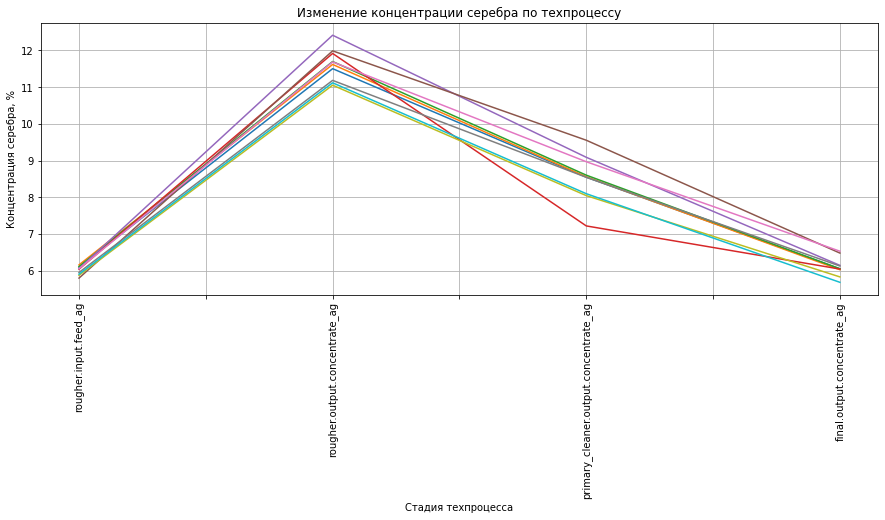

In [61]:
for i in range(0,10):
    (ag.loc[i].plot(rot=90, grid=True, figsize=(15, 5))
      .set(xlabel='Стадия техпроцесса', 
      ylabel='Концентрация серебра, %',  
      title='Изменение концентрации серебра по техпроцессу'));

Концентрация серебра растет на стадии флотации и затем уменшается на стадиях очистки

**Свинец**

In [62]:
pb = train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb',
            'final.output.concentrate_ag']]

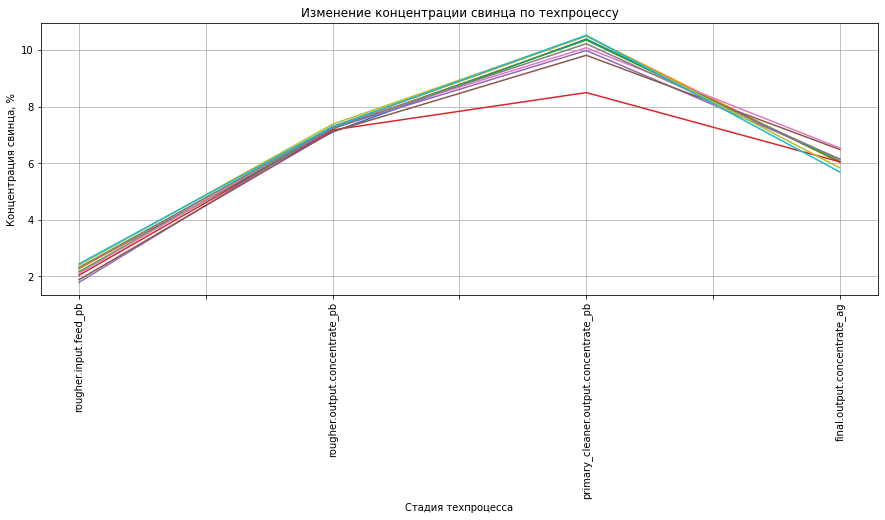

In [63]:
for i in range(0,10):
    (pb.loc[i].plot(rot=90, grid=True, figsize=(15, 5))
      .set(xlabel='Стадия техпроцесса', 
      ylabel='Концентрация свинца, %',  
      title='Изменение концентрации свинца по техпроцессу'));

Концентрация свинца растет на стадиях флотации и первичной очистки и уменьшается на втором этапе очистки

## 2.2 Сравнение размеров гранул сырья на обучающей и тестовой выборках

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели может быть неправильной.

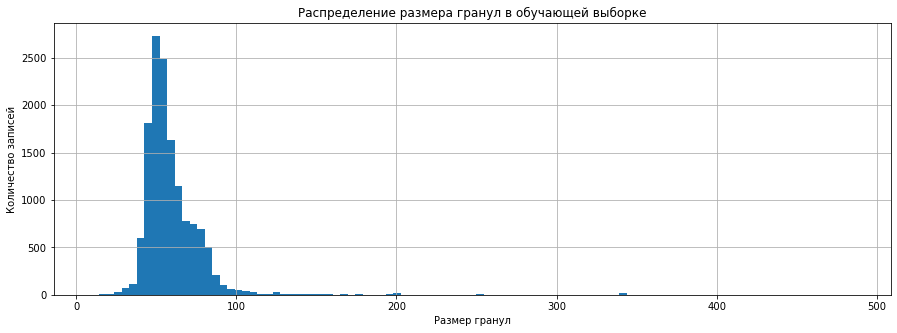

In [64]:
(train['rougher.input.feed_size'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Размер гранул', 
      ylabel='Количество записей',  
      title='Распределение размера гранул в обучающей выборке'));

In [65]:
train['rougher.input.feed_size'].describe()

count    14063.000000
mean        60.051421
std         23.352223
min          9.659576
25%         48.872120
50%         55.190726
75%         65.775326
max        484.967466
Name: rougher.input.feed_size, dtype: float64

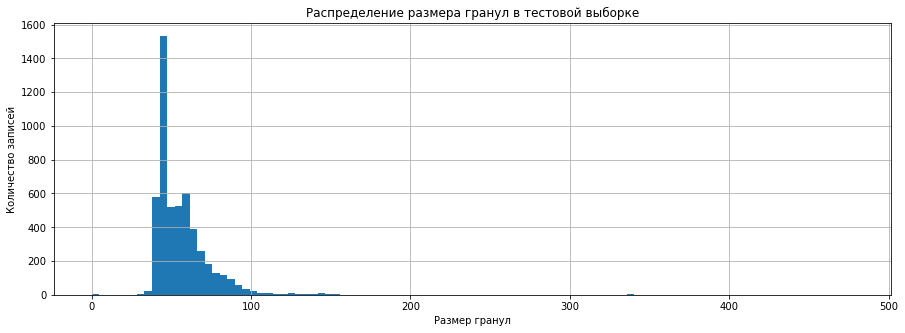

In [66]:
(test['rougher.input.feed_size'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Размер гранул', 
      ylabel='Количество записей',  
      title='Распределение размера гранул в тестовой выборке'));

In [67]:
test['rougher.input.feed_size'].describe()

count    5171.000000
mean       56.457237
std        22.012336
min         0.046369
25%        43.878942
50%        51.154707
75%        62.587821
max       477.445473
Name: rougher.input.feed_size, dtype: float64

Распределения достаточно близки. Можно переходить к следующей стадии

## Исследование суммарной концентрации всех веществ на разных стадиях
### Стадия флотации

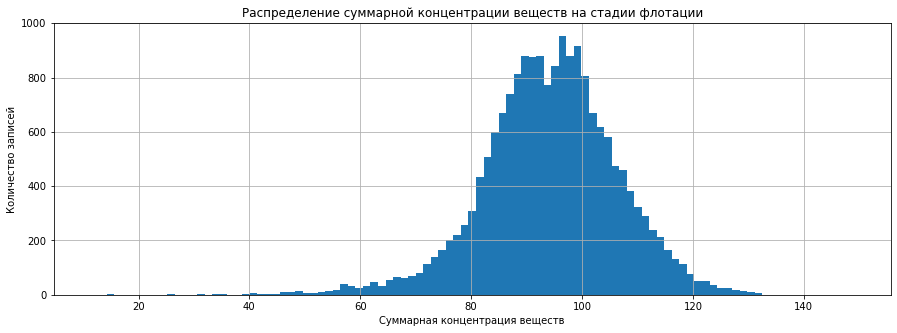

In [68]:
full['rougher.input.feed_sum'] = (full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] +
                                  full['rougher.input.feed_sol'] + full['rougher.input.feed_au'] +
                                  full['rougher.input.floatbank10_sulfate'] + full['rougher.input.floatbank10_xanthate'] +
                                  full['rougher.input.floatbank11_sulfate'] + full['rougher.input.floatbank11_xanthate']
                                  )
(full['rougher.input.feed_sum'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Суммарная концентрация веществ', 
      ylabel='Количество записей',  
      title='Распределение суммарной концентрации веществ на стадии флотации'));

In [69]:
full['rougher.input.feed_sum'].describe()

count    18627.000000
mean        94.156282
std         12.324680
min         11.563012
25%         86.956098
50%         94.571452
75%        101.863163
max        148.804721
Name: rougher.input.feed_sum, dtype: float64

Так как в данных речь идет о двух флоатационных установках, то сумма всех веществ может быть больше 100%. Тем не менее очень низкие значения исходных веществ являются аномалиями. Оценим количество строк с низкими суммарными значениями и удалим их.

In [70]:
ROUGHER_INPUT_FEED_SUM_TRH = 50
(full['rougher.input.feed_sum'] < ROUGHER_INPUT_FEED_SUM_TRH).mean()

0.004107309971924717

In [71]:
train = train.drop(train.index[train['date'].isin(full[full['rougher.input.feed_sum'] < ROUGHER_INPUT_FEED_SUM_TRH]['date'])])
test = test.drop(test.index[test['date'].isin(full[full['rougher.input.feed_sum'] < ROUGHER_INPUT_FEED_SUM_TRH]['date'])])
full = full.drop(full.index[full['rougher.input.feed_sum'] < ROUGHER_INPUT_FEED_SUM_TRH])
(full['rougher.input.feed_sum'] < ROUGHER_INPUT_FEED_SUM_TRH).mean()

0.0

### Стадия первичной очистки

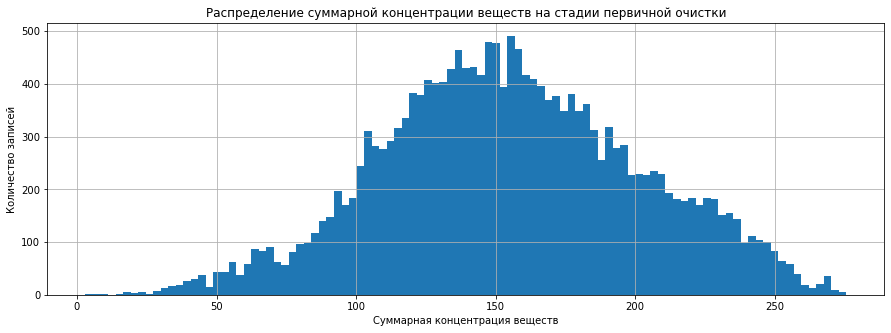

In [72]:
full['primary_cleaner.input.feed_sum'] = (full['primary_cleaner.input.sulfate'] + 
                                          full['primary_cleaner.input.depressant'] + 
                                          full['primary_cleaner.input.xanthate']
                                          )
(full['primary_cleaner.input.feed_sum'].hist(bins=101, figsize=(15,5))
 .set(xlabel='Суммарная концентрация веществ', 
      ylabel='Количество записей',  
      title='Распределение суммарной концентрации веществ на стадии первичной очистки'));

In [73]:
full['primary_cleaner.input.feed_sum'].describe()

count    19042.000000
mean       155.273336
std         46.075931
min          2.996929
25%        123.780778
50%        153.588641
75%        186.569113
max        275.590625
Name: primary_cleaner.input.feed_sum, dtype: float64

In [74]:
PRIMARY_CLEANER_INPUT_FEED_SUM_LOW_TRH = 25
(full['primary_cleaner.input.feed_sum'] < PRIMARY_CLEANER_INPUT_FEED_SUM_LOW_TRH).mean()

0.001096319498825372

In [75]:
PRIMARY_CLEANER_INPUT_FEED_SUM_HI_TRH = 262.5
(full['primary_cleaner.input.feed_sum'] > PRIMARY_CLEANER_INPUT_FEED_SUM_HI_TRH).mean()

0.004333072304881232

In [76]:
drop_date = full[(full['primary_cleaner.input.feed_sum'] < PRIMARY_CLEANER_INPUT_FEED_SUM_LOW_TRH) |
                 (full['primary_cleaner.input.feed_sum'] > PRIMARY_CLEANER_INPUT_FEED_SUM_HI_TRH)]['date']

train = train.drop(train.index[train['date'].isin(drop_date)])
test = test.drop(test.index[test['date'].isin(drop_date)])
full = full.drop(full.index[full['date'].isin(drop_date)])
((full['primary_cleaner.input.feed_sum'] < PRIMARY_CLEANER_INPUT_FEED_SUM_LOW_TRH) |
 (full['primary_cleaner.input.feed_sum'] > PRIMARY_CLEANER_INPUT_FEED_SUM_HI_TRH)).mean()

0.0

<a id='section3'> </a>

# 3. Модель

Создадим функции для вычисления sMAPE и итогового sMAPE

In [77]:
def sMAPE_score(y_true, y_pred):
    if ((np.abs(y_true) + np.abs(y_pred)) == 0).any():
        print('Деление на ноль')
        return np.nan
    else:
        return np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) / len(y_true)

In [78]:
def total_sMAPE_score(y_true, y_pred):
    y_rougher_true = y_true[:, 0]
    y_final_true = y_true[:, 1]
    y_rougher_pred = y_pred [:, 0]
    y_final_pred =  y_pred [:, 1]
    return 0.25 * sMAPE_score(y_rougher_true, y_rougher_pred) + 0.75 * sMAPE_score(y_final_true, y_final_pred)

In [79]:
y_col = ['rougher.output.recovery', 'final.output.recovery']
x_col = test.columns.drop(['date'] + y_col)
x_col

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Отмасштабируем числовые признаки

In [80]:
num_col = x_col
scaler = StandardScaler()
scaler.fit(train[num_col])
df_train_scaled = train.copy()
df_train_scaled[num_col] = scaler.transform(train[num_col])
df_train_scaled.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_manual_calc,final.output.recovery_manual_calc
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-0.634824,-0.755698,-1.162139,-0.379454,-0.860018,-0.427504,-0.943996,-2.636206,87.107763,98.744534
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-0.663304,-0.697565,-1.142620,-0.428003,-0.876585,-0.430356,-0.970720,-2.475028,86.843261,98.617181
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-0.670500,-0.694162,-1.137179,-0.426937,-0.871502,-0.428699,-0.965426,-2.518689,86.842308,98.570585
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-0.653959,-0.695198,-1.154454,-0.402725,-0.877882,-0.421988,-0.969463,-2.480590,87.226430,97.296409
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-0.662820,-0.692796,-1.162126,-0.467598,-0.892384,-0.424556,-0.971018,-2.520535,86.688794,98.513891


In [81]:
df_test_scaled = test.copy()
df_test_scaled[num_col] = scaler.transform(test[num_col])

In [82]:
df_train_scaled[x_col].shape

(13963, 52)

### Линейная регрессия

In [83]:
linear_regression_model = LinearRegression()
scores = cross_val_score(linear_regression_model, df_train_scaled[x_col], df_train_scaled[y_col].values, cv=5, 
                         scoring = make_scorer(total_sMAPE_score, greater_is_better=False), n_jobs=-1)
scores

array([-0.1139, -0.0891, -0.0935, -0.0767, -0.121 ])

In [84]:
print("Модель показывает sMAPE: %0.4f. СКО оценки при этом: %0.4f" % (-scores.mean(), scores.std()))

Модель показывает sMAPE: 0.0989. СКО оценки при этом: 0.0163


### Случайный лес

In [85]:
# # ниже представлен код который переберает число деревьев и их глубину и ищет наилучшую модель по заданному критерию
# # так как перебор занимает порядка 4 часов код закомментирован.  
# # модель с уже найдеными лучшими параметрами представлена в следующей ячейке

# best_forest_depth = 1
# best_forest_n_estimators = 1
# best_forest_mean_score = 100
# best_forest_std_score = 0
# for n_estimators in tqdm(range(1, 151, 10)):
#     for depth in range(1, 21, 2):
#         random_forest_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=depth, random_state=42, n_jobs=-1)
#         scores = cross_val_score(random_forest_model, df_train_scaled[x_col], df_train_scaled[y_col].values, cv=5, 
#                                  scoring = make_scorer(total_sMAPE_score, greater_is_better=False), n_jobs=-1)
#         if -scores.mean() < best_forest_mean_score:
#             best_forest_depth = depth
#             best_forest_n_estimators = n_estimators
#             best_forest_mean_score = -scores.mean()
#             best_forest_std_score = scores.std()

# print("Модель показывает итоговый sMAPE: %0.4f. СКО оценки при этом: %0.4f" % (best_forest_mean_score, best_forest_std_score))
# print('Число деревьев:', best_forest_n_estimators)
# print('Глубина деревьев %0.4f' % (best_forest_depth))

In [86]:
best_random_forest_model = RandomForestRegressor(n_estimators=91,
                                                 max_depth=3, random_state=42)
scores = cross_val_score(best_random_forest_model, df_train_scaled[x_col], df_train_scaled[y_col].values, cv=5, 
                                 scoring = make_scorer(total_sMAPE_score, greater_is_better=False), n_jobs=-1)

print("Модель показывает итоговый sMAPE: %0.4f. СКО оценки при этом: %0.4f" % (-scores.mean(), scores.std()))

Модель показывает итоговый sMAPE: 0.0860. СКО оценки при этом: 0.0075


### CatBoost

Проверим на кросвалидации модель CatBoost создадим отдельную модель для оценки эффективности восстановления золота после всего техцикла и после этапа флотации. Начнем с полного техцикла

In [87]:
cv_final_pool = Pool(df_train_scaled[x_col], df_train_scaled[y_col].values[:, 1])

params = {"learning_rate": 0.5,
          "iterations": 100,
          "loss_function": "MAPE",
          "eval_metric": "SMAPE",
          "random_state": 42,
          "verbose": 10}

scores = cv(cv_final_pool, params, fold_count=5)

0:	learn: 66.2725004	test: 66.3976286	best: 66.3976286 (0)	total: 1.61s	remaining: 2m 39s
10:	learn: 9.1182255	test: 9.3970187	best: 9.3970187 (10)	total: 16.2s	remaining: 2m 10s
20:	learn: 8.1006745	test: 8.4576197	best: 8.4576197 (20)	total: 31.8s	remaining: 1m 59s
30:	learn: 7.9223955	test: 8.3809232	best: 8.3796052 (29)	total: 47.2s	remaining: 1m 45s
40:	learn: 7.8521963	test: 8.3588391	best: 8.3588391 (40)	total: 1m 2s	remaining: 1m 29s
50:	learn: 7.7940053	test: 8.3452146	best: 8.3452146 (50)	total: 1m 17s	remaining: 1m 14s
60:	learn: 7.7509304	test: 8.3350259	best: 8.3350259 (60)	total: 1m 33s	remaining: 59.7s
70:	learn: 7.7012057	test: 8.3121604	best: 8.3121604 (70)	total: 1m 47s	remaining: 44s
80:	learn: 7.6433393	test: 8.2844740	best: 8.2841609 (78)	total: 2m 3s	remaining: 28.9s
90:	learn: 7.6130264	test: 8.2701194	best: 8.2701194 (90)	total: 2m 19s	remaining: 13.8s
99:	learn: 7.5790692	test: 8.2489582	best: 8.2489582 (99)	total: 2m 32s	remaining: 0us


In [88]:
scores.tail()

,iterations,test-SMAPE-mean,test-SMAPE-std,train-SMAPE-mean,train-SMAPE-std,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std
95,95,8.262986,0.303188,7.597908,0.218584,0.104728,0.007339,0.080898,0.002540
96,96,8.258249,0.309737,7.587467,0.231360,0.104700,0.007244,0.080776,0.002679
97,97,8.254646,0.310634,7.584516,0.232177,0.104505,0.006960,0.080739,0.002690
98,98,8.251807,0.313180,7.582043,0.233197,0.105790,0.009309,0.080724,0.002687
99,99,8.248958,0.313571,7.579069,0.234118,0.105551,0.008956,0.080691,0.002696


Модель дает средний sMAPE для данного параметра на валидации 8,37 при СКО 0,13. Оценим sMAPE для прогноза восстановления золота после этапа флотации

In [ ]:
cv_rougher_pool = Pool(df_train_scaled[x_col], df_train_scaled[y_col].values[:, 0])

params = {"learning_rate": 0.5,
          "iterations": 100,
          "loss_function": "MAPE",
          "eval_metric": "SMAPE",
          "random_state": 42,
          "verbose": 10}

scores = cv(cv_rougher_pool, params, fold_count=5)

0:	learn: 66.3333602	test: 66.4048808	best: 66.4048808 (0)	total: 1.56s	remaining: 2m 34s
10:	learn: 5.1545445	test: 5.3289013	best: 5.3289013 (10)	total: 18.5s	remaining: 2m 29s
20:	learn: 4.2873227	test: 4.5242387	best: 4.5242387 (20)	total: 35.2s	remaining: 2m 12s
30:	learn: 3.9895829	test: 4.3103194	best: 4.3103194 (30)	total: 49.3s	remaining: 1m 49s


In [ ]:
scores.tail()

Модель дает средний sMAPE для данного параметра на валидации 3,98 при СКО 0,19. 

Создадим модели с требуемыми параметрами

In [ ]:
catboost_rougher_model = CatBoostRegressor(learning_rate=0.5, iterations=100,
                                          loss_function='MAPE', eval_metric='SMAPE', random_state=42, verbose=10)
catboost_rougher_model.fit(cv_rougher_pool)

In [ ]:
catboost_final_model = CatBoostRegressor(learning_rate=0.5, iterations=100,
                                          loss_function='MAPE', eval_metric='SMAPE', random_state=42, verbose=10)
catboost_final_model.fit(cv_final_pool)

### Тестирование модели

In [ ]:
# создадим массив y_true_test в который вложены пары истинных значений целевых переменных 
# (аналогично тому как возвращает предсказания метод predict в sklearn)

y_true_test = []
for i in df_test_scaled.index:
    y_true_test.append([df_test_scaled.loc[i, 'rougher.output.recovery'], 
                        df_test_scaled.loc[i, 'final.output.recovery']])
y_true_test = np.array(y_true_test)
y_true_test

In [ ]:
# аналогично создадим массив предсказаний модели catboost

y_pred_cb = []
y_pred_rougher = catboost_rougher_model.predict(df_test_scaled[x_col])
y_pred_final = catboost_final_model.predict(df_test_scaled[x_col])
for i, j in zip(y_pred_rougher, y_pred_final):
    y_pred_cb.append([i, j])
    
y_pred_cb = np.array(y_pred_cb)
y_pred_cb

In [ ]:
print('Итоговый sMAPE для модели catboost на тестовой выборке: %0.4f' 
      % total_sMAPE_score(y_true_test, y_pred_cb))

In [ ]:
best_random_forest_model.fit(df_train_scaled[x_col], df_train_scaled[y_col])
print('Итоговый sMAPE для модели случайного леса на тестовой выборке: %0.4f' 
      % total_sMAPE_score(y_true_test, best_random_forest_model.predict(df_test_scaled[x_col])))

In [ ]:
linear_regression_model.fit(df_train_scaled[x_col], df_train_scaled[y_col])
print('Итоговый sMAPE для модели линейной регрессии на тестовой выборке: %0.4f'
     % total_sMAPE_score(y_true_test, linear_regression_model.predict(df_test_scaled[x_col])))

### Проверка модели на адекватность
Заполним предсказания медианой и оценим итоговый sMAPE

In [ ]:
dummy_regressor = DummyRegressor(strategy='median')
dummy_regressor.fit(df_train_scaled[x_col], df_train_scaled[y_col])
total_sMAPE_score(y_true_test, dummy_regressor.predict(df_test_scaled[x_col]))

Итоговый sMAPE предсказания по медиане 0,07374

<a id='section4'> </a>

# Выводы

В процессе исследования были проведены следующие работы:
1. Проведена подготовка данных (проверена формула вычисления эффективности обогощения, проведена предобработка данных, заполнены пропуски)
2. Проанализированы данные (исследовано изменение концентрации металлов при переходе по стадиям технологического цикла, проанализированы распределения размеров гранул на обучающей и тестовой выборках, исследованы суммарные концентрации)
3. Построена модель прогнозирования (написана функция вычисления итогового sMAPE, обучены и проверены модели линейной регресии, случайного леса, catboost)


По результатам исследования сделаны следующие выводы:
* Концентрация золота увеличивается при переходе от одной стадии технологического цикла к следующей
* Концентрация серебра растет на стадии флотации и затем уменшается на стадиях очистки
* Концентрация свинца растет на стадиях флотации и первичной очистки и уменьшается на втором этапе очистки
* Распределения размеров гранул сырья на тестовой и обучающей выборке достаточно близки
* Заполнение целевых признаков медианой дает значение итогового sMAPE - 0,07374
* Из рассмотренных моделей наилучший результат по итоговму sMAPE на тестовой выборке показал catboost - 0,0664, второй по данному показателю оказалась модель линейной регрессии с результатом 0,0708
* модель случайного леса проигрывает другим рассмотренным моделям, а так же предсказанию по медиане и показывает результат 0.0825


Для дальнейшей работы рекомендуется рассмотреть возможность внедрения разработанной модели на основе catboost, а так же оценить возможность объединения предсказаний нескольких моделей для повышения точности.